# 2018 10 25 : Spatiotemporal filters vs Gabor II : Electric Boogaloo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

video = np.load('LifeOfBrian.npy')
print('video.shape=', video.shape)

video.shape= (640, 36, 64)


In [2]:
video = np.swapaxes(video, 0, -1)
print('video.shape=', video.shape)

video.shape= (64, 36, 640)


In [3]:
video = np.swapaxes(video, 0, 1)
print('video.shape=', video.shape)

video.shape= (36, 64, 640)


In [4]:
video = video[:, :36, :]

# Filters definition

In [5]:
def spatial_filter(wx=5., wy=5., xres=.1, yres=.1, sigma_center=1., sigma_surround=1.2,
                   x_trans=0, y_trans=0, theta=0, end_multiplier=-1.):
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    '''
    x = np.arange((-wx+x_trans), (wx+x_trans), xres)
    y = np.arange((-wy+y_trans), (wy+y_trans), yres)
    X,Y = np.meshgrid(x,y)

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (1.0 / sigma_center**2) * np.exp(-.5*(radius / sigma_center)**2)
    surround = (1.0 / sigma_surround**2) * \
        np.exp(-.5*(radius / sigma_surround)**2)

    Z = surround - center
    Z *= end_multiplier
    return X, Y, Z

def temporal_filter(t = 1 , response_time = 175, refrac_time = 50,
                   K1 = .92, c1 = 0.2, n1 = 7, t1 = -6,
                   K2 = .2, c2 = .12, n2 = 8, t2 = -6,
                   baseline = 0., gain = 90):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''
    
    #t = np.arange(0, total_time*t_res, t_res)
    p = baseline
    p += K1 * ( (c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / (n1**2)*np.exp(-n1)
    p -= K2 * ( (c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / (n2**2)*np.exp(-n2)
    return p*gain #oups je me suis planté d'un facteur 90, c'est un sacré miss



############
# Constants
############
total_time = 3000 #ms,
fps = 24 #c'est pas très gamer tout ça 
filter_size = 2.
filter_res = .1

coo_min = len(video[:,:,0])/2 - 5
coo_max = len(video[:,:,0])/2 + 5
grid_res = .5

filters_coordinates = np.mgrid[coo_min:coo_max:grid_res].reshape(2,-1).T

print('Filter array size', filters_coordinates.shape)

Filter array size (10, 2)


# Video handling

Video shape (36, 36, 640)
Frames shape (36, 36)


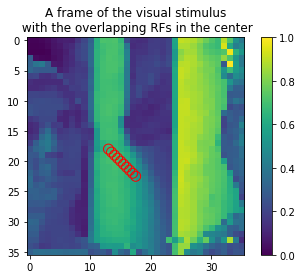

In [6]:
print('Video shape', video.shape)
print('Frames shape',video[:,:,0].shape)
plt.imshow(video[:,:,0], cmap = plt.cm.viridis)
plt.colorbar()
for filt in filters_coordinates :
    plt.scatter(filt[0], filt[1], color = 'r', s = 10**2, facecolor = 'None', edgecolor = 'r')

plt.title('A frame of the visual stimulus\n with the overlapping RFs in the center')
#plt.savefig('./figs/2018_10_24_MontyPython_frame.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')
plt.show()

Total frames 640
Frame duration at 24 fps: 125.0
Number of second of video at 24fps: 27
Sanity check passed


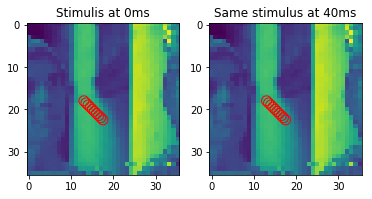

In [7]:
print('Total frames', video.shape[-1])
print('Frame duration at 24 fps:', total_time/fps)
print('Number of second of video at 24fps:', video[:,:,::24].shape[-1])
frame_duration = int(total_time/fps)

stimuli = []
for ms in range(int(total_time/frame_duration)) :
    for same_frame in range(frame_duration):
        stimuli.append(video[:,:,ms])
while len(stimuli) < total_time:
    stimuli.append(stimuli[-1])
        
#Check that a random pixel is different from the same pixel in the previous frame
if stimuli[0][0,30]!=stimuli[frame_duration+1][0,30] : print('Sanity check passed')
    
fig, axs = plt.subplots(1,2)
axs[0].imshow(stimuli[0])
axs[0].set_title('Stimulis at 0ms')
for filt in filters_coordinates :
    axs[0].scatter(filt[0], filt[1], color = 'r', s = 10**2, facecolor = 'None', edgecolor = 'r')
axs[1].imshow(stimuli[4])
axs[1].set_title('Same stimulus at 40ms')
for filt in filters_coordinates :
    axs[1].scatter(filt[0], filt[1], color = 'r', s = 10**2, facecolor = 'None', edgecolor = 'r')
plt.show()

In [8]:
###########
# Multiple filters 
###########

convo_list = []
st_list = [] # a list of spatiotemporal filters for tests with plotting
Xs = []
Ys = []

for filt in tqdm(range(len(filters_coordinates)), 'Making filters') :
    X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                           xres = filter_res, yres = filter_res,
                           x_trans= filters_coordinates[filt][0],
                          y_trans = filters_coordinates[filt][1]) 
    t = [temporal_filter(i, gain = 55) for i in np.linspace(0,total_time, total_time)]
    
    #Convolution coordinates, centered around the filter and the size of the filter space
    X_convo_minus = int(filters_coordinates[filt][0]-filter_size)
    X_convo_plus = int(filters_coordinates[filt][0]+filter_size)
    Y_convo_minus = int(filters_coordinates[filt][1]-filter_size)
    Y_convo_plus = int(filters_coordinates[filt][1]+filter_size)
    
    activations = []
    for i in np.linspace(0, total_time-1, total_time):
        activations.append(np.max(stimuli[int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                  *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))
    
    ys = np.convolve(t, activations)
    st = Z[:, :, None] * ys[None, None, :]
    
    convo_list.append(ys)
    st_list.append(st)
    
    Xs.append(X)
    Ys.append(Y)

Making filters: 100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


Text(0.5, 0.92, "Multiple RF response from Monty Python's Flying Circus ")

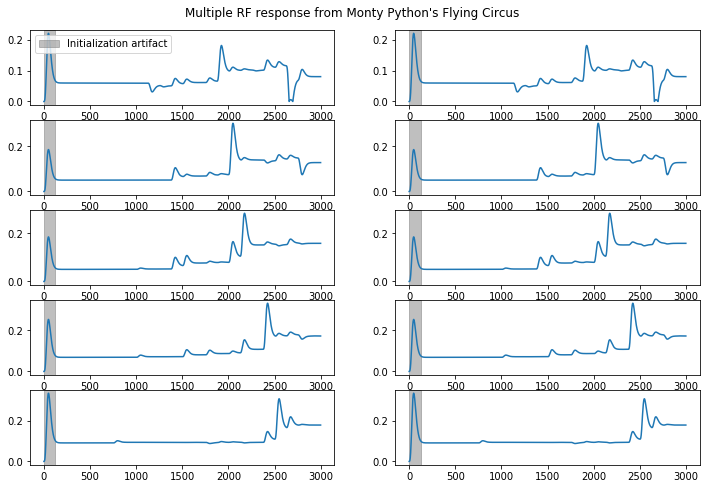

In [9]:
plt.figure(figsize=(12, 8))

st_levels = []
for ft in range(len(st_list)):
    ax = plt.subplot(5, 2,ft+1)
    
    st_level = []
    for i in range(len(stimuli)):
        st_level.append(np.max(st_list[ft][:,:,i]))
    st_levels.append(st_level)
    
    ax.plot(st_level)
    ax.axvspan(0, 125, alpha=0.5, color='gray', label = 'Initialization artifact' if ft == 0 else '')
    if ft == 0 : ax.legend()
    
plt.suptitle(
    "Multiple RF response from Monty Python's Flying Circus ", x=.5, y=.92)


# Gabor filters

In [10]:
parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
 'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
 'do_whitening': True, 'dpi': 450,'edgefigpath': 'results/edges','edgematpath': 'cache_dir/edges',
 'ext': '.pdf','figpath': 'results','figsize': 14.0,'formats': ['pdf', 'png', 'jpg'],
 'mask_exponent': 3.0, 'matpath': 'cache_dir','n_theta': 24, 'noise': 0.1, 'seed': None,
 'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
 'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
 'white_recompute': False, 'white_steepness': 4.0}

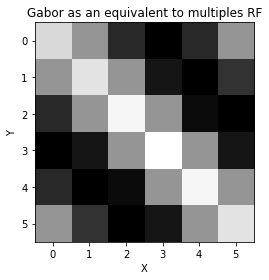

In [11]:
from LogGabor import LogGabor
N_X, N_Y, N_frame = video.shape
N_X = int(N_X/7)+1
N_Y = int(N_Y/7)+1

lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))

B_theta = 10 /180 * np.pi
params= {'sf_0':.05, 'B_sf': 1.5, 'B_theta': B_theta}

N_phase = 2
theta = 3*np.pi/4
phi = np.zeros((1, N_phase, N_X, N_Y))

x = N_X/2 #gabor centered
y = N_Y/2
params.update(theta=theta)
for i_phase in range(N_phase):
    phase = i_phase * np.pi/2
    kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
    phi[0, i_phase, :] = lg.normalize(kernel)

fig, ax = plt.subplots()
ax.imshow(phi[0, 0,], cmap=plt.gray()) #[theta_nbr, phase, content]
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Gabor as an equivalent to multiples RF')
plt.tight_layout()

Text(0.5, 0.85, 'Gabor filter applied to the same blue zone as the RF filters')

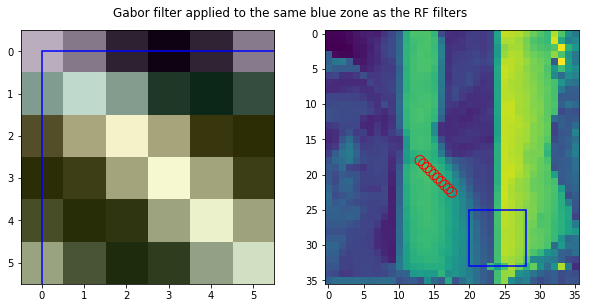

In [12]:
import matplotlib.patches as patches
fig, ax = plt.subplots(1,2, figsize = (10,6))
gabor_video = np.asarray(stimuli).T[23:31, 23:31]

ax[0].imshow(gabor_video[:,:,0], cmap = plt.cm.viridis)
ax[0].imshow(phi[0,0,], cmap = plt.cm.gray, alpha = .8)
rect = patches.Rectangle((0,0),7,7,linewidth=1.5,edgecolor='b',facecolor='none')
ax[0].add_patch(rect)

ax[1].imshow(video[:,:,0], plt.cm.viridis)
rect = patches.Rectangle((20,25),8,8,linewidth=1.5,edgecolor='b',facecolor='none')
ax[1].add_patch(rect)
for filt in filters_coordinates :
    ax[1].scatter(filt[0], filt[1], color = 'r', s = 10**2, facecolor = 'None', edgecolor = 'r')
    
plt.suptitle(x = .5, y = .85, t ='Gabor filter applied to the same blue zone as the RF filters')
#fig.savefig('./figs/2018_10_25_Applied_Gabor.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')

In [13]:
#Je fais un petit gabor parce que j'ai fais des petits champs récepteurs qui couvrent 8 degrés d'arc
gabor_video = np.asarray(stimuli).T[23:31, 23:31]
gabor_video = gabor_video.reshape((8*8, total_time))
print('gabor_video.shape', gabor_video.shape)

gabor_video.shape (64, 3000)


In [14]:
phi_ = phi.reshape((1, 2, 8*8))
print('phi_.shape', phi_.shape)

ValueError: cannot reshape array of size 72 into shape (1,2,64)

In [ ]:
code = phi_ @ gabor_video

plt.plot(code[0][0], label = 'Phase')
plt.plot(code[0][1], label = 'Antiphase')
plt.legend()

# V1 membrane potential driver

In [ ]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
from pyNN.parameters import Sequence
from pyNN.utility.plotting import Figure, Panel

In [ ]:
def VanillaRasterPlot( SpikesP, SpikesE, spike_thresh,injections, title = 'Title', markersize = .5, 
                         figsize = (9,6), shifts = None):
    
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
        
        fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = figsize)
        
        color=iter(plt.cm.gist_heat(np.linspace(.5,.8, 20)))
        for traces in injections:
            axs[0].plot(traces.get_data(), color = next(color))
        axs[0].set_ylabel('I (nA)')
        axs[0].set_title('Input')
        axs[0].set_xticklabels([])
        
        axs[1].plot(SpikesE.analogsignals[0].times, SpikesE.analogsignals[0])
        axs[1].set_ylabel('Voltage')
        axs[1].set_title('V1 neuron with alpha-function dynamics ')
        
        plt.xlabel('Time (ms)')
        
        return fig, axs  

In [ ]:
##########
# Params #
##########
import time
now = time.time()
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick
                    }

injection_sampling_rate = 1
current_times = np.linspace(0,total_time,len(st_levels[0][::injection_sampling_rate]))
current_list = []
##############
# Simulation #
##############
sim.setup(timestep=0.01)

post = sim.Population(1, sim.IF_cond_alpha(**neuron_params),
                    initial_values={"v": neuron_params["v_reset"]}, label="postsynaptic")



for inputs in range(len(st_levels)):
    '''current_times = np.linspace(0, len(st_levels[inputs][::injection_sampling_rate]),
                                len(st_levels[inputs][::injection_sampling_rate]))
    '''
    current_levels = st_levels[inputs][::injection_sampling_rate]
    current_levels = np.asarray(current_levels)
    
    current_input = sim.StepCurrentSource(times = current_times,
                                     amplitudes = current_levels)
    current_input.inject_into(post)
    current_list.append(current_input)
    current_input.record()

post.record(['spikes', 'v'])

sim.run(total_time)
sim.end()

#PLOTTING and DATA
post_v = post.get_data().segments[0]
sig = post_v.analogsignals[0]


markersize = 3
fig, axs = VanillaRasterPlot(SpikesP = None, SpikesE = post_v, injections = current_list,
                 spike_thresh = neuron_params['v_thresh'], markersize = 3)

then = time.time()
print('Simulation done in %.2f s' % (then-now))
#fig.savefig('./figs/2018_10_24_Filters_to_V1_angular.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')

In [ ]:
##########
# Params #
##########
import time
now = time.time()
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick
                    }

injection_sampling_rate = 1
current_times = np.linspace(0,total_time,len(code[0][0][::injection_sampling_rate]))
current_list = []
##############
# Simulation #
##############
sim.setup(timestep=0.01)

post = sim.Population(1, sim.IF_cond_alpha(**neuron_params),
                    initial_values={"v": neuron_params["v_reset"]}, label="postsynaptic")


current_levels = code[0][1][::injection_sampling_rate]/1.72
current_input = sim.StepCurrentSource(times = current_times,
                                 amplitudes = current_levels)
current_input.inject_into(post)
current_list.append(current_input)
current_input.record()

post.record(['spikes', 'v'])

sim.run(total_time)
sim.end()

#PLOTTING and DATA
post_v2 = post.get_data().segments[0]
sig = post_v2.analogsignals[0]


markersize = 3
fig, axs = VanillaRasterPlot(SpikesP = None, SpikesE = post_v2, injections = current_list,
                 spike_thresh = neuron_params['v_thresh'], markersize = 3)

axs[0].set_ylim(.25, .45)
then = time.time()
print('Simulation done in %.2f s' % (then-now))
#fig.savefig('./figs/2018_10_24_GABOR_to_V1_.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')

# Gabor vs Filter : numerical comparison

In [ ]:
fig, axs = plt.subplots(2,1, figsize = (10,6))
axs[0].plot(post_v.analogsignals[0].times, post_v.analogsignals[0])
axs[0].set_ylim(-57,-52)
axs[0].set_title('Filters')
axs[0].set_xticklabels([])


axs[1].plot(post_v2.analogsignals[0].times, post_v2.analogsignals[0])
axs[1].set_title('Gabor')

plt.suptitle ('Qualitatively related activations from ST or Gabor')

In [ ]:
mean_filter_input = np.mean(st_levels, axis = 0) #mean of RF filters
mean_gabor_input = np.mean(code[0], axis = 0) #mean of phase and antiphase activations

#rectifying by the same factor and aligning
plt.plot(mean_gabor_input/1.7-.09)
plt.plot(mean_filter_input/1.7)

plt.title('Both input functions seem VERY roughly equal\n Pearson R = .385')
plt.show()

In [ ]:
print('Mean input correlation : %.3f'% np.corrcoef(mean_gabor_input, mean_filter_input)[0][1])
print('Phase to filter correlation : %.3f' % np.corrcoef(code[0][1], mean_filter_input)[0][1])
print('Antiphase to filter correlation : %.3f' % np.corrcoef(code[0][0], mean_filter_input)[0][1])
print('--')
print('Neuron output correlation : %.3f' % np.corrcoef(post_v.analogsignals[0].T, post_v2.analogsignals[0].T)[0][1])